In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from math import pow

In [65]:
CN=17 #medium copy number
mi= 0.0028
NA=6.2*10**(23)
kmng=(18*10**(-3))*60 #RBS034
kluxr=(27*10**(-3))*60 #1.62
kd1=100*10**(-9)
kd2=20*10**(-9)
k_min_one=10
k_min_two=1
k1=k_min_one/kd1
k2=k_min_two/kd2
kdlux=10*10**(-9)
d_mrnamng=0.019
d_mng=0.023
d_mrnaluxr=0.347
d_mon=0.156
d_dim=0.017
d_luxr=0.002
d_AHL=0.01
D=10
Nmin=0.129*10**(7)
Nmax=2.142*10**(7)
Vecoli=10**(-15)
Vbead=200*10**(-6)
Vc=Vecoli/Vbead
n=0.5
b_plux=0.1 #percentage of leakage
plux=0.79 #promoters
pcon=(58.5*10**(-3))*60 #3.51
small=1e-45 #for potential division with 0
a_luxr=49.78
plux_pfc=2.25*(6896.40/100000)
a_luxr_pf=a_luxr/100
a_mng=0.44
t=np.linspace(0, 600) 

In [67]:
#model_fit_functions
def molecules(number): #turns nM to molecules
    return number*NA*10**(-15)

def molar(number): #turns molecules to uM
    return(number*10**(15))/NA

def oplo_fit(x,t): #for oplo
    Ni=x[0]
    AHL_ext=x[1]
    AHL_int=x[2]
    LuxR=x[3]
    Mon=x[4]
    Dim=x[5]
    mng=x[6]
    
    dNdt=small+mi*Ni*(1-(Ni/Nmax))
    dAHL_extdt=small+D*Vc*Ni*(AHL_int-AHL_ext)-(d_AHL+mi)*AHL_ext
    dAHLdt=small+k_min_one*Mon-k1*AHL_int*LuxR -(d_AHL+mi)*AHL_int +D*Vc*10**(11)*(AHL_ext-AHL_int)
    dLuxRdt=small+ molar(((a_luxr*CN))/(d_mrnaluxr+mi)) - (d_luxr+mi)*LuxR + k_min_one*Mon - k1*LuxR*AHL_int
    dMondt=small+ (k1*LuxR*AHL_int+2*k_min_two*Dim-k_min_one*Mon-2*k2*(Mon**2)-(d_mon+mi)*Mon)
    dDimdt=small+ (k2*(Mon**2)-k_min_two*Dim-(d_dim+mi)*Dim)
    dmngdt =small+ ((a_mng*CN)/(d_mrnamng+mi))*(b_plux+(1-b_plux)*((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))) - (d_mng+mi)*mng
    
    return [dNdt,dAHL_extdt,dAHLdt,dLuxRdt,dMondt,dDimdt,dmngdt]

def pf_model(x,t): #for pf
    Ni=x[0]
    AHL_ext=x[1]
    AHL_int=x[2]
    LuxR=x[3]
    Mon=x[4]
    Dim=x[5]
    mng=x[6]
    
    dNdt=small+mi*Ni*(1-(Ni/Nmax))
    dAHL_extdt=small+D*Vc*Ni*(AHL_int-AHL_ext)-(d_AHL+mi)*AHL_ext
    dAHLdt=small+k_min_one*Mon-k1*AHL_int*LuxR -(d_AHL+mi)*AHL_int +D*Vc*10**(11)*(AHL_ext-AHL_int)
    Hill_LuxR=((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))
    dLuxRdt=small+ molar(((a_luxr_pf*CN))/(d_mrnaluxr+mi))*(b_plux+(1-b_plux)*((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))) - (d_luxr+mi)*LuxR + k_min_one*Mon - k1*LuxR*AHL_int
    dMondt=small+ (k1*LuxR*AHL_int+2*k_min_two*Dim-k_min_one*Mon-2*k2*(Mon**2)-(d_mon+mi)*Mon)
    dDimdt=small+ (k2*(Mon**2)-k_min_two*Dim-(d_dim+mi)*Dim)
    dmngdt =small+ ((a_mng*CN)/(d_mrnamng+mi))*(b_plux+(1-b_plux)*((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))) - (d_mng+mi)*mng
    
    return [dNdt,dAHL_extdt,dAHLdt,dLuxRdt,dMondt,dDimdt,dmngdt]

def pfc_model(x,t): #for pfc
    Ni=x[0]
    AHL_ext=x[1]
    AHL_int=x[2]
    LuxR=x[3]
    Mon=x[4]
    Dim=x[5]
    mng=x[6]
    
    dNdt=small+mi*Ni*(1-(Ni/Nmax))
    dAHL_extdt=small+D*Vc*Ni*(AHL_int-AHL_ext)-(d_AHL+mi)*AHL_ext
    dAHLdt=small+k_min_one*Mon-k1*AHL_int*LuxR -(d_AHL+mi)*AHL_int +D*Vc*10**(11)*(AHL_ext-AHL_int)
    dLuxRdt=small+ molar(((a_luxr_pf*CN))/(d_mrnaluxr+mi))*(1+b_plux+(1-b_plux)*((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))) - (d_luxr+mi)*LuxR + k_min_one*Mon - k1*LuxR*AHL_int
    dMondt=small+ (k1*LuxR*AHL_int+2*k_min_two*Dim-k_min_one*Mon-2*k2*(Mon**2)-(d_mon+mi)*Mon)
    dDimdt=small+ (k2*(Mon**2)-k_min_two*Dim-(d_dim+mi)*Dim)
    dmngdt =small+ ((a_mng*CN)/(d_mrnamng+mi))*(b_plux+(1-b_plux)*((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))) - (d_mng+mi)*mng
    
    return [dNdt,dAHL_extdt,dAHLdt,dLuxRdt,dMondt,dDimdt,dmngdt]

def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(paras,))
    return x

Text(0.5, 1.0, 'OpLo Fit')

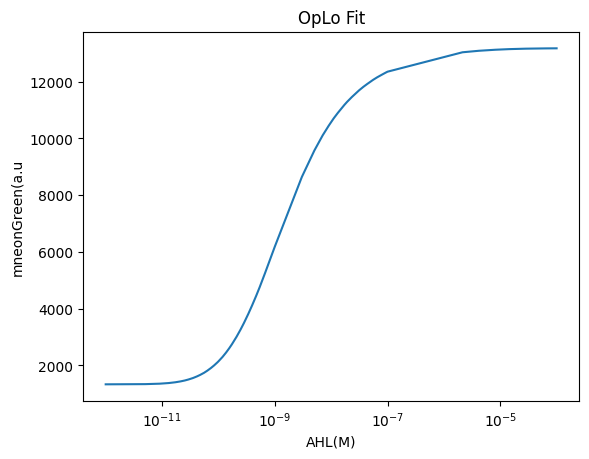

In [68]:
mng_temp=[] #for oplo
AHL_values_0=np.linspace(10**(-10),10**(-8))
AHL_values_1=np.linspace(10**(-8),10**(-7))
AHL_values_2=np.linspace(10**(-7),10**(-5))
AHL_values_3=np.linspace(10**(-5),10**(-2))
AHL_values=np.concatenate([AHL_values_0,AHL_values_1,AHL_values_2,AHL_values_3])*10**(-2)
for i in range(np.shape(AHL_values)[0]):
    x0=[Nmin,AHL_values[i],0,0,0,0,0]
    solution=odeint(oplo_fit,x0,t)
    mng_temp.append(max(solution[:,6]))
plt.semilogx(AHL_values,mng_temp)
plt.xlabel('AHL(M)')
plt.ylabel('mneonGreen(a.u')
plt.title('OpLo Fit')

Text(0.5, 1.0, 'Compare fit')

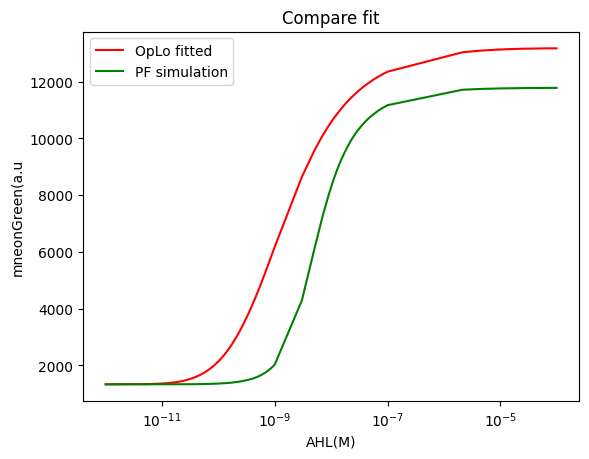

In [69]:
mng_temp_2=[] #compare oplo-pf
mng_temp_3=[]
for i in range(np.shape(AHL_values)[0]):
    x0=[Nmin,AHL_values[i],0,0,0,0,0]
    solution=odeint(pf_model,x0,t)
    mng_temp_2.append(max(solution[:,6]))
plt.semilogx(AHL_values,mng_temp,'r',label='OpLo fitted')
plt.semilogx(AHL_values,mng_temp_2,'g',label='PF simulation')
plt.xlabel('AHL(M)')
plt.ylabel('mneonGreen(a.u')
plt.legend()
plt.title('Compare fit')

Text(0.5, 1.0, 'Compare OpLo-PF-PFc')

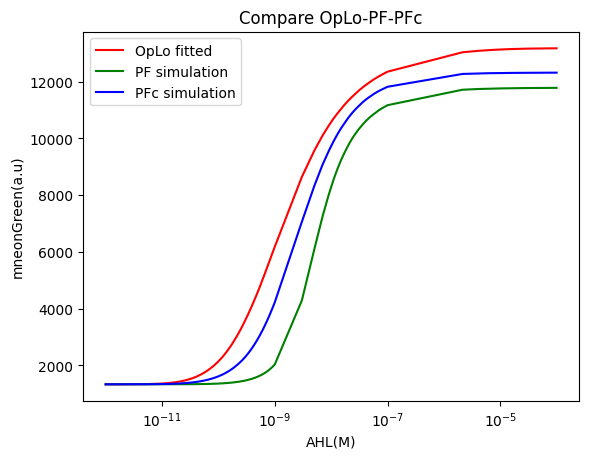

In [70]:
mng_temp_3=[] #compare oplo=pf=pfc
for i in range(np.shape(AHL_values)[0]):
    x0=[Nmin,AHL_values[i],0,0,0,0,0]
    solution=odeint(pfc_model,x0,t)
    mng_temp_3.append(max(solution[:,6]))
plt.semilogx(AHL_values,mng_temp,'r',label='OpLo fitted')
plt.semilogx(AHL_values,mng_temp_2,'g',label='PF simulation')
plt.semilogx(AHL_values,mng_temp_3,'b',label='PFc simulation')
plt.xlabel('AHL(M)')
plt.ylabel('mneonGreen(a.u)')
plt.legend()
plt.title('Compare OpLo-PF-PFc')

Text(0.5, 1.0, 'Compare All RBSs for same n=0.5')

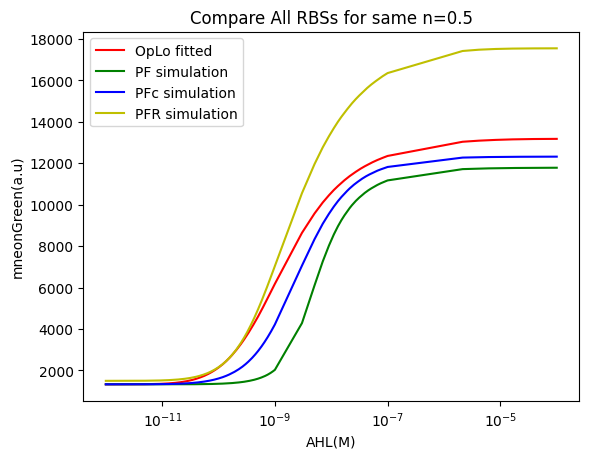

In [133]:
small=0
CN=17
mi=0.0028 #FROM OPLO
t=np.linspace(0, 600) 
NA=6.2*10**(23)
#for transcription and translation rates of constructs
pluxr=155*60*10**(-3)
kluxr=27*60*10**(-3)
a1=pluxr*kluxr
plux_repr=3.69*10**(-3)*60
kphlf=4*10**(-3)*60
a2=plux_repr*kphlf
phybrid=10*60*10**(-3)
kmng=18.3*60*10**(-3)
a3=phybrid*kmng
n=0.5
#leakiness of promoters
b_plux=0.1 #FROM OPLO
b_pphlf=0.1
#for luxr-ahl dimer
kd1=100*10**(-9)
kd2=20*10**(-9)
k_min_one=10
k_min_two=1
k1=k_min_one/kd1
k2=k_min_two/kd2
kdlux=10*10**(-9) #FROM OPLO
kdlux_repr=kdlux
kdphlf=2*10**(-7)
#degradation rates
d_mrnamng=0.023 #FROM OPLO 
d_mng=0.019 #FROM OPLO
d_mrnaluxr=0.347
d_mon=0.156
d_dim=0.017
d_luxr=0.002
d_AHL=0.01
d_mrnaphlf=0.02*60
d_phlf=0.042
#for Diffusion
D=10
Nmin=0.129*10**(7)
Nmax=2.142*10**(7)
Vecoli=10**(-15)
Vbead=200*10**(-6)
Vc=Vecoli/Vbead

def pfr_model(x,t): #pfr
    Ni=x[0]
    AHL_ext=x[1]
    AHL_int=x[2]
    LuxR=x[3]
    Mon=x[4]
    Dim=x[5]
    phlf=x[6]
    mng=x[7]

    
    dNdt=small+mi*Ni*(1-(Ni/Nmax))
    dAHL_extdt=small+D*Vc*Ni*(AHL_int-AHL_ext)-(d_AHL+mi)*AHL_ext
    dAHLdt=small+k_min_one*Mon-k1*AHL_int*LuxR -(d_AHL+mi)*AHL_int +D*Vc*10**(11)*(AHL_ext-AHL_int)
    dLuxRdt=small+ molar(((a1*CN))/(d_mrnaluxr+mi))*(b_plux+(1-b_plux)*((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))) - (d_luxr+mi)*LuxR + k_min_one*Mon - k1*LuxR*AHL_int
    dMondt=small+ (k1*LuxR*AHL_int+2*k_min_two*Dim-k_min_one*Mon-2*k2*(Mon**2)-(d_mon+mi)*Mon)
    dDimdt=small+ (k2*(Mon**2)-k_min_two*Dim-(d_dim+mi)*Dim)
    dphlfdt=small+molar((a2*CN)/(d_mrnaphlf+mi))*(b_plux+(1-b_plux)*((pow(abs(kdlux),n))/((pow(abs(Dim),n))+(pow(kdlux,n))))) - d_phlf*phlf
    Hill_1=(b_pphlf+(1-b_pphlf)*((pow(abs(Dim),n))/((pow(abs(Dim),n))+(pow(kdlux,n)))))
    Hill_2=(b_plux+(1-b_plux)*((pow(abs(kdphlf),n))/((pow(abs(phlf),n))+(pow(kdphlf,n)))))
    dmngdt =small+ ((a3*CN)/(d_mrnamng+mi))*Hill_1*Hill_2 - (d_mng+mi)*mng
    
    return [dNdt,dAHL_extdt,dAHLdt,dLuxRdt,dMondt,dDimdt,dphlfdt,dmngdt]

mng_temp_4=[]
for i in range(np.shape(AHL_values)[0]):
    x0=[Nmin,AHL_values[i],0,0,0,0,0,0]
    solution=odeint(pfr_model,x0,t)
    mng_temp_4.append(max(solution[:,7]))

plt.semilogx(AHL_values,mng_temp,'r',label='OpLo fitted')
plt.semilogx(AHL_values,mng_temp_2,'g',label='PF simulation')
plt.semilogx(AHL_values,mng_temp_3,'b',label='PFc simulation')
plt.semilogx(AHL_values,mng_temp_4,'y',label='PFR simulation')
plt.xlabel('AHL(M)')
plt.ylabel('mneonGreen(a.u)')
plt.legend()
plt.title('Compare All RBSs for same n=0.5')





In [134]:
from scipy.stats import linregress #compute slope to choose

norm=10000

slope, intercept, r_value, p_value, std_err = linregress(AHL_values, mng_temp)
slope_2, intercept, r_value, p_value, std_err = linregress(AHL_values, mng_temp_2)
slope_3, intercept, r_value, p_value, std_err = linregress(AHL_values, mng_temp_3)
slope_4, intercept, r_value, p_value, std_err = linregress(AHL_values, mng_temp_4)
print("OpLo slope is: ", slope/norm, "*10^(5)")
print("PF slope is: ",slope_2/norm,"*10^(5)")
print("PFc slope is: ",slope_3/norm,"*10^(5)")
print("PFR slope is: ",slope_4/norm,"*10^(5)")

OpLo slope is:  9865.963124200252 *10^(5)
PF slope is:  10158.234094974923 *10^(5)
PFc slope is:  9804.986979851485 *10^(5)
PFR slope is:  14004.347302977303 *10^(5)
